# Object detection model with transforms

> Object Detection Model with transforms


- skip_showdoc: true
- skip_exec: true

## COCO

the training/validation split was changed from 83K/41K to 118K/5K. The new split uses the same images and annotations. The 2017 test set is a subset of 41K images of the 2015 test set. Additionally, the 2017 release contains a new unannotated dataset of 123K images.

### Data download

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz


In [ ]:
# dataset = foz.load_zoo_dataset(
#     name="coco-2017",
#     dataset_dir= "Data/coco",
#     splits=["validation","train"],
#     classes=['person', 'bicycle', 'car', 'motorcycle',],
#     max_samples=200,
# )

In [ ]:
# print(dataset.default_classes)

In [ ]:
# Visualize the dataset in the FiftyOne App
# session = fo.launch_app(dataset)

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Create a histogram plot
output_notebook()

Loading BokehJS ...

### Dataset and DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import VisionDataset, CocoDetection
from torchinfo import summary
import torch.utils.data
from torch.utils.data import DataLoader

In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
classes = ['0', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
           'boat', 'traffic light', 'fire hydrant', '12', 'stop sign', 'parking meter', 'bench',
           'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
           '26', 'backpack', 'umbrella', '29', '30', 'handbag', 'tie', 'suitcase', 'frisbee',
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
           'surfboard', 'tennis racket', 'bottle', '45', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
           'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '66', 'dining table', '68', '69',
           'toilet', '71', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
           'oven', 'toaster', 'sink', 'refrigerator', '83', 'book', 'clock', 'vase', 'scissors',
           'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
classes[2]

'bicycle'

In [ ]:
# desired_size = (400, 600) 
# Define transforms
# Define transforms for the dataset
transform2 = v2.Compose(
    [
        v2.ToImage(),
        # v2.Resize(size = desired_size),  # Resize image
        v2.RandomPhotometricDistort(p=0.2),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomHorizontalFlip(p=0.4),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

transform_default = v2.Compose(
    [
        v2.ToImage(),
        # v2.Resize(size = desired_size),  # Resize image
        # v2.RandomPhotometricDistort(p=0.2),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.4),
        # # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [ ]:
train_path = './Data/coco/train'
val_path = './Data/coco/validation'

# Load KITTI train dataset
train_dataset = CocoDetection(root=f'{train_path}/data',
                              annFile=f'{train_path}/labels.json', 
                              transforms = transform2)

# Load KITTI test dataset
test_dataset = CocoDetection(root=f'{val_path}/data',
                            annFile=f'{val_path}/labels.json',
                            transforms = transform_default)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels"))

In [ ]:
len(train_dataset2), len(test_dataset2)

(200, 200)

In [ ]:
batch_size = 4

train_loader = DataLoader(train_dataset2,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)),
                          num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2,
                         batch_size=batch_size,
                         shuffle=True,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)

# Create DataLoader for test dataset
test_loader1 = DataLoader(test_dataset2,
                         batch_size=4,
                         shuffle=True,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)


In [ ]:
sample = train_dataset2[10]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_cv2, label, color = (0, 255, 0), convert = True):
    if convert:
        image_cv2 = cv2.cvtColor((image_cv2 * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    if 'scores' in label:
        for bbox, item, score in zip(label['boxes'], label['labels'], label['scores']):
            if score > 0.2:
                cv2.rectangle(image_cv2,
                              (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                              color, 2)
            
                # Display the label
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image_cv2, classes[item.item()],
                            (int(bbox[0]), int(bbox[1]) - 10),
                            font, 0.5, color, 2, cv2.LINE_AA)
    else:
        for bbox, item in zip(label['boxes'], label['labels']):
            # Draw the bounding box
            cv2.rectangle(image_cv2,
                          (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                          color, 2)
        
            # Display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_cv2, classes[item.item()],
                        (int(bbox[0]), int(bbox[1]) - 10),
                        font, 0.5, color, 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb


def show_single_image(image, label):
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    return image_rgb


def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    show_single_image(image, label)

# Define a function to display images
def show_images(images, labels, **kwargs):
    if len(images) == 1:
        show_single_image(images[0], labels[0])
    else:
        nrows = int(math.sqrt(len(images)))
        ncols = int(np.floor(len(images)/nrows))
            
        fig, axes = plt.subplots(nrows, ncols, **kwargs)
        # Adjust the spacing between subplots
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
        # Display the image using Matplotlib
        for ax, image, label in zip(axes.flat, images, labels):
            # Convert image to numpy array and adjust pixel values
            image_np = np.asarray(image).transpose((1, 2, 0))
            image_rgb = cv2_show(image_np, label)
            
            # Display image
            ax.imshow(image_rgb)
            ax.axis('off')
    
        for ax in axes.flat[len(images):]:
            ax.axis('off')
        plt.show()

In [ ]:
images, label = train_dataset2[8]


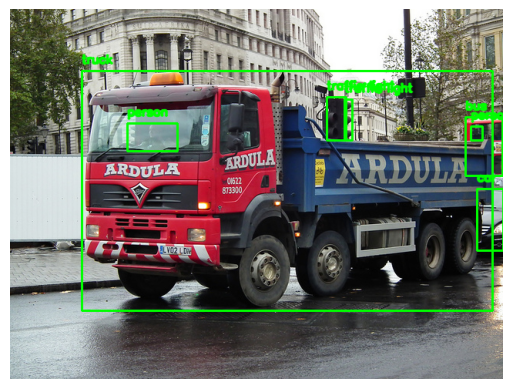

In [ ]:
show_image(train_dataset2[16])

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


In [ ]:
images[0].shape

torch.Size([3, 823, 1097])

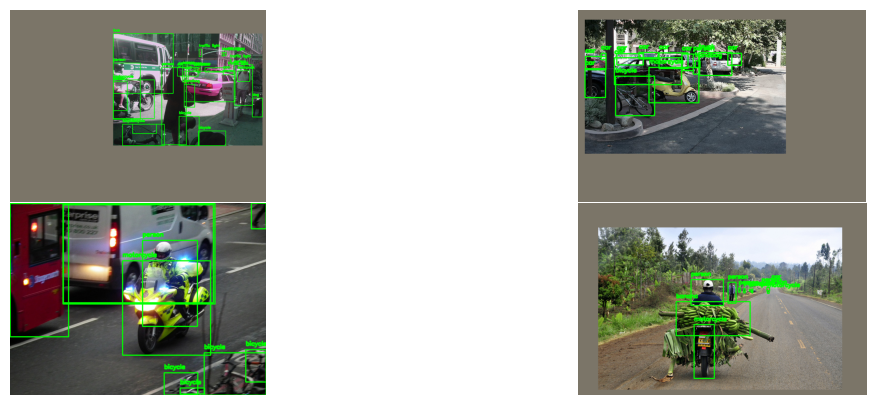

In [ ]:
show_images(images, labels, figsize=(15, 5))

### Model

In [ ]:
import torch 
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.transform import GeneralizedRCNNTransform


In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

# random_input = np.random.rand(1, 3, 100, 100)
# # Load the ResNet-18 backbone
# backbone = resnet_fpn_backbone(backbone_name='resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)
# summary(backbone, input_size=random_input.shape, verbose = 0, depth  = 5, col_names = (
#                 "input_size",
#                 "output_size",
#                 "num_params",
#                 "params_percent",
#                 "kernel_size",
#                 "mult_adds",
#                 "trainable",
#             ))

In [ ]:
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280
# summary(backbone, input_size=random_input.shape, verbose = 0, depth  = 5, col_names = (
#                 "input_size",
#                 "output_size",
#                 "num_params",
#                 "params_percent",
#                 "kernel_size",
#                 "mult_adds",
#                 "trainable",
#             ))

In [ ]:
# # Define the resize parameters
# min_size = (300,)  # Change this to your desired minimum size
# max_size = 500    # Change this to your desired maximum size
# # Create the Faster R-CNN model with the modified transform
# model = FasterRCNN(backbone = backbone, num_classes=80)
# model.transform.min_size = min_size
# model.transform.max_size = max_size
# model = model.to(device)

In [ ]:
# weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# preprocess = weights.transforms()
# model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
# model = model.to(device)



In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

weights= FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
preprocess = weights.transforms()
model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights, box_score_thresh=0.9)
model = model.to(device)


In [ ]:
def start_tensorboard(file_name):
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    from datetime import datetime
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'{file_name} {formatted_time}')
    print(f'{file_name} {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    
    
    # writer.add_graph(model, images)
    writer.flush()
    ###################################################
    return writer

In [ ]:
# Define an optimizer (you can use any optimizer from torch.optim)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=0.7)
# Define optimizer and learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

epochs = 10


In [ ]:
def val_model(current_epoch, n_total_steps):
    # Evaluation loop
    model.train()
    total_loss = 0.0
    
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader):
            # Move input data to GPU
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss', total_loss / len(test_loader), current_epoch * n_total_steps)
    writer.flush()
    # print(f'[step:{epoch * n_total_steps + i}/ {epochs * n_total_steps} ] loss: {running_loss / 100}')
    
    running_loss = 0.0
    ###################################################
    # Print average loss for the evaluation
    print(f"Evaluation Loss : {total_loss / len(test_loader):.4f}")

In [ ]:
# Training loop
running_loss = 0.0
n_total_steps = len(train_loader)

writer = start_tensorboard(f'coco/mobilenet_v3 {epochs} {batch_size} {learning_rate}')

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for i, (imgs, targets) in enumerate(tqdm(train_loader)):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        running_loss += losses.item()

        if (i+1) % 5 == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 5, epoch * n_total_steps + i)
            writer.flush()
            # print(f'[step:{epoch * n_total_steps + i}/ {epochs * n_total_steps} ] loss: {running_loss / 100}')
            
            running_loss = 0.0
            ###################################################
    # Update learning rate scheduler
    lr_scheduler.step()
    val_model(epoch, n_total_steps)
    # Print average loss for the epoch
    print(f"Average Loss: {total_loss / len(train_loader):.4f}")

coco/mobilenet_v3 10 4 0.001 19:02:48


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.77it/s]


Evaluation Loss : 0.8237
Average Loss: 0.9554


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.52it/s]


Evaluation Loss : 0.8223
Average Loss: 0.9234


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.69it/s]


Evaluation Loss : 0.8235
Average Loss: 0.9248


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


Evaluation Loss : 0.8249
Average Loss: 0.9150


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


Evaluation Loss : 0.8206
Average Loss: 0.8965


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


Evaluation Loss : 0.8144
Average Loss: 0.8897


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]


Evaluation Loss : 0.8189
Average Loss: 0.9043


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


Evaluation Loss : 0.8214
Average Loss: 0.9054


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.69it/s]


Evaluation Loss : 0.8223
Average Loss: 0.9047


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]

Evaluation Loss : 0.8185
Average Loss: 0.9074


In [ ]:
model.eval()
# Get a batch of images and labels from the data loader
examples = iter(test_loader1)

In [ ]:
images, labels = next(examples)
imgs = [img.to(device) for img in images]

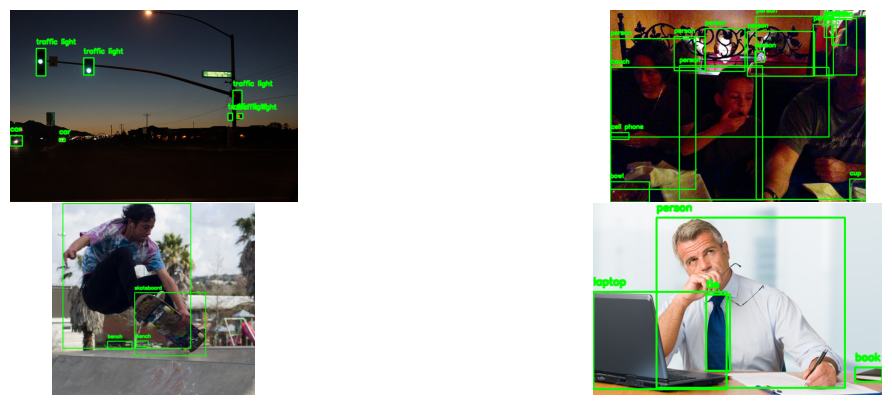

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
loss_dict = model(imgs)

In [ ]:
loss_dict = [{k: v.to('cpu') for k, v in t.items()} for t in loss_dict] 

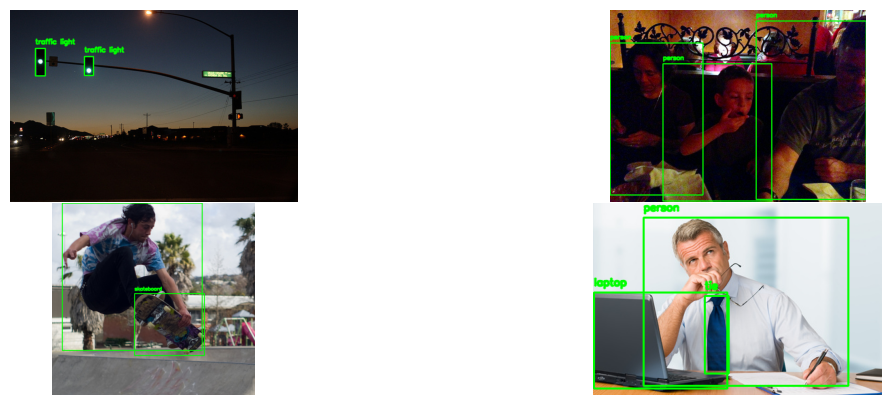

In [ ]:
show_images(images, loss_dict, figsize=(15, 5))

In [ ]:
############## TENSORBOARD ########################
writer.close()
###################################################

## Eval

In [ ]:
# Run inference
model.eval()
predictions = []
targets_list = []
image_list = []
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        imgs = [img.to(device) for img in images]
        targets_list.extend(targets)
        image_list.extend(images)
        prediction = model(imgs)
        predictions.extend(prediction)

for prediction in predictions:
    for a in prediction:
        prediction[f'{a}'] = prediction[f'{a}'].to('cpu')


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.46it/s]


In [ ]:
def show_prediction_and_truth(image, label, pred):
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label, color = (0, 255, 0))
    image_rgb1 = cv2_show(image_rgb, pred, color = (255, 0, 0), 
                          convert = False)
    # Display the image using Matplotlib
    plt.imshow(image_rgb1)
    plt.axis('off')
    plt.show()

    return image_rgb1

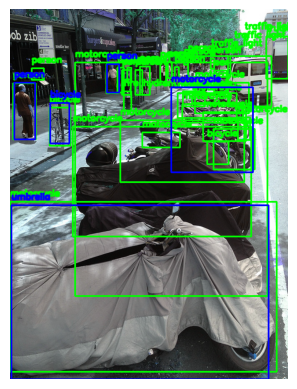

In [ ]:
_ = show_prediction_and_truth(image_list[0], targets_list[0], predictions[0])

In [ ]:
def calculate_precision(prediction, target, iou_threshold=0.5):
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()

    target_boxes = target['boxes'].numpy()
    target_labels = target['labels'].numpy()

    num_preds = len(pred_boxes)
    num_targets = len(target_boxes)

    true_positives = np.zeros(num_preds)
    false_positives = np.zeros(num_preds)

    # Initialize an array to keep track of whether each ground truth box has been detected
    detected = np.zeros(num_targets)
    false_negatives = np.zeros(num_targets)

    for pred in range(num_preds):
        max_iou = 0
        max_idx = -1

        for targ in range(num_targets):
            iou = calculate_iou(pred_boxes[pred], target_boxes[targ])

            # Check if the prediction is a true positive
            if iou > iou_threshold and not detected[targ] and pred_labels[pred] == target_labels[targ]:
                true_positives[pred] = 1
                detected[targ] = 1

                # Update the maximum IoU and corresponding index
                if iou > max_iou:
                    max_iou = iou
                    max_idx = targ

        # If no true positive is found, the prediction is a false positive
        if true_positives[pred] == 0:
            false_positives[pred] = 1
            
    # Calculate false negatives
    false_negatives = 1 - detected
    
    # Calculate precision
    if num_preds:
        precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
    else:
        precision = 0
    # Calculate recall
    recall = np.sum(true_positives) / num_targets

    # Calculate accuracy
    accuracy = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives) + np.sum(false_negatives))

    return precision, recall, accuracy

In [ ]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

In [ ]:
def calculate_mAP(predictions, targets_list, iou_threshold=0.5):
    num_classes = 91
    ap_sum = 0
    num_classes_with_predictions = 0

    for class_idx in range(1, num_classes + 1):  # Class indices start from 1
        class_predictions = []
        class_targets = []

        # Collect predictions and targets for the current class across all images
        for pred, target in zip(predictions, targets_list):
            class_mask = pred['labels'] == class_idx
            class_predictions.append({
                'boxes': pred['boxes'][class_mask],
                'scores': pred['scores'][class_mask]
            })
            class_mask = target['labels'] == class_idx
            class_targets.append({
                'boxes': target['boxes'][class_mask]
            })

        # Calculate AP for the current class
        if len(class_predictions) > 0:
            ap = calculate_ap(class_predictions, class_targets, iou_threshold)
            ap_sum += ap
            num_classes_with_predictions += 1

    # Calculate mAP
    if num_classes_with_predictions == 0:
        return 0
    else:
        mAP = ap_sum / num_classes_with_predictions
        return mAP

In [ ]:
def calculate_ap(predictions, targets, iou_threshold=0.5):
    num_targets = len(targets)

    # Initialize arrays to store precision and recall values
    precision = []
    recall = []

    # Iterate over different score thresholds
    for score_threshold in np.linspace(0, 1, 101):  # 101 thresholds from 0 to 1
        # Compute TP, FP, FN at the current threshold
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        # Iterate over predictions
        for pred in predictions:
            # Ensure pred is a dictionary
            if not isinstance(pred, dict):
                raise TypeError("Each prediction should be a dictionary.")

            # Check if the prediction score exceeds the threshold
            mask = pred['scores'] >= score_threshold
            pred_boxes = pred['boxes'][mask]

            # Compute TP, FP, FN for the current prediction
            if len(pred_boxes) > 0:
                ious = [calculate_iou(pred_box, targ_box) for targ_box in targets]
                max_iou = max(ious)
                if max_iou >= iou_threshold:
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                false_positives += 1

        # Compute precision and recall at the current threshold
        if true_positives + false_positives == 0:
            prec = 0
        else:
            prec = true_positives / (true_positives + false_positives)

        if true_positives + false_negatives == 0:
            rec = 0
        else:
            rec = true_positives / (true_positives + false_negatives)

        # Append precision and recall values
        precision.append(prec)
        recall.append(rec)

    # Calculate area under precision-recall curve (AP)
    ap = np.trapz(precision, recall)

    return ap

In [ ]:
len(targets_list)

200

In [ ]:
precision_l = []
recall_l = []
accuracy_l = []

for pred, targ in zip(predictions, targets_list):
    precision, recall, accuracy = calculate_precision(pred, targ)
    precision_l.append(precision)  
    recall_l.append(recall)   
    accuracy_l.append(accuracy)   


In [ ]:
avg_precision = np.array(precision_l).mean()
avg_recall = np.array(recall_l).mean()
avg_accuracy = np.array(accuracy_l).mean()

In [ ]:
avg_precision, avg_recall, avg_accuracy

(0.8925669191919192, 0.4526122054997975, 0.4376806827844392)